In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
import random
from scipy.stats import randint, uniform
from sklearn.neural_network import MLPRegressor

In [2]:
#Reading data from the excel sheet
dataset = pd.read_excel("mgg_data.XLSX", index_col = 0)

In [3]:
#Printing the first 5 row
dataset.head()

,Brüt m²,Net m²,Oda Sayısı,Banyo Sayısı,Binadaki Kat Sayısı,Bulunduğu Kat,Bina Yaşı,Isıtma Tipi,Mobilya Durumu,Kullanım Durumu,...,Kimden,Krediye Uygun,Price,Location Lat,Location Lon,Location1,Location2,Location3,Aidat,Takasa Uygun
1,95,85.0,2+1,1,4,1,0,Kombi (Doğalgaz),Eşyasız,Boş,...,Danışman,Evet,325000,41.056436,28.924630,Karlıtepe,Gaziosmanpaşa,İstanbul,NaN,NaN
2,152,102.0,3+1,2,10-20 arası,14,0,Merkezi Sistem (Isı Payı Ölçer),Eşyasız,Boş,...,NaN,Hayır,550000,41.125386,28.765559,Kayabaşı,Başakşehir,İstanbul,0.0,NaN
3,125,90.0,2+1,2,20 ve üzeri,7,0,Merkezi Sistem (Isı Payı Ölçer),Eşyasız,Boş,...,Danışman,Evet,410000,41.010598,28.682872,Zafer,Esenyurt,İstanbul,0.0,NaN
4,175,160.0,3+1,2,5,2,2,Kombi (Doğalgaz),Eşyasız,Boş,...,Danışman,Evet,370000,40.976841,28.675703,Marmara,Beylikdüzü,İstanbul,50.0,NaN
5,166,150.0,3+1,2,9,Bahçe katı,0,Klima,Sadece Beyaz Eşya,Boş,...,Danışman,Evet,1530000,40.988106,28.883287,Kartaltepe,Bakırköy,İstanbul,0.0,NaN


In [4]:
#Sum of the Nan Values for Each Column
dataset.isnull().sum()

Brüt m²                   0
Net m²                   60
Oda Sayısı                2
Banyo Sayısı              1
Binadaki Kat Sayısı     202
Bulunduğu Kat           173
Bina Yaşı               186
Isıtma Tipi             204
Mobilya Durumu          491
Kullanım Durumu         235
Yapının Durumu         1848
Konut Şekli             948
Kira Getirisi          1246
Kimden                 2048
Krediye Uygun             0
Price                     0
Location Lat             52
Location Lon             52
Location1                 0
Location2                 0
Location3                 0
Aidat                  1620
Takasa Uygun           3711
dtype: int64

In [5]:
#Drop the columns which are unnecesary & irrelevant
dataset = dataset.drop(["Takasa Uygun"], axis = 1)
dataset = dataset.drop(["Location1"], axis = 1)
dataset = dataset.drop(["Location2"], axis = 1)
dataset = dataset.drop(["Location3"], axis = 1)
dataset = dataset.drop(dataset[dataset["Net m²"] <= 10].index)
dataset = dataset.drop(dataset[dataset["Kira Getirisi"] > dataset["Price"]].index)

In [6]:
#Drop the Nan Value intersection of 3 columns
dataset = dataset.dropna(subset=['Kullanım Durumu', 'Yapının Durumu','Konut Şekli'], how='all')

In [7]:
#Fill the Nan Values with mean of all cells in column
dataset["Net m²"].fillna(value = dataset["Net m²"].mean(), inplace = True)
dataset["Kira Getirisi"].fillna(value = 0, inplace = True)
dataset["Aidat"].fillna(value = 0, inplace = True)

In [8]:
avg_rent = np.mean(dataset[dataset["Kira Getirisi"] > 0]["Kira Getirisi"])
rent_col = dataset['Kira Getirisi']
rent_col.replace(to_replace = 0, value = avg_rent, inplace=True)

In [9]:
rent_col

1       1500.000000
2       1820.715922
3       1820.715922
4       1820.715922
5       1820.715922
           ...     
4995    1820.715922
4996    1820.715922
4997    1820.715922
4999    1820.715922
5000    2500.000000
Name: Kira Getirisi, Length: 4812, dtype: float64

In [10]:
#Replacing NaN Aidat values with mean of positive values
avg_aidat = np.mean(dataset[dataset["Aidat"] > 0]["Aidat"])
aidat_col = dataset["Aidat"]
aidat_col.replace(to_replace = 0, value = avg_aidat, inplace = True)

In [11]:
aidat_col

1       150.940587
2       150.940587
3       150.940587
4        50.000000
5       150.940587
           ...    
4995     25.000000
4996     45.000000
4997    150.940587
4999    150.940587
5000    219.000000
Name: Aidat, Length: 4812, dtype: float64

In [12]:
#Dummy Encoding
pd.get_dummies(dataset['Isıtma Tipi'])
dataset = pd.get_dummies(dataset, columns=['Isıtma Tipi'])
pd.get_dummies(dataset['Mobilya Durumu'])
dataset = pd.get_dummies(dataset, columns=['Mobilya Durumu'])
pd.get_dummies(dataset['Kullanım Durumu'])
dataset = pd.get_dummies(dataset, columns=['Kullanım Durumu'])
pd.get_dummies(dataset['Yapının Durumu'])
dataset = pd.get_dummies(dataset, columns=['Yapının Durumu'])
pd.get_dummies(dataset['Konut Şekli'])
dataset = pd.get_dummies(dataset, columns=['Konut Şekli'])
pd.get_dummies(dataset['Kimden'])
dataset = pd.get_dummies(dataset, columns=['Kimden'])# direkt for açılıp 1,0,-1 verilebilir.
pd.get_dummies(dataset['Binadaki Kat Sayısı'])
dataset = pd.get_dummies(dataset, columns=['Binadaki Kat Sayısı'])
pd.get_dummies(dataset['Bulunduğu Kat'])
dataset = pd.get_dummies(dataset, columns=['Bulunduğu Kat'])

In [13]:
#Label Encoding
le = preprocessing.LabelEncoder()
KrediyeUygun = le.fit_transform(dataset["Krediye Uygun"])
dataset["Krediye Uygun"] = KrediyeUygun

In [14]:
#Locations ----- > 0-1 arasına scale edilebilir 
print(dataset["Location Lat"].mean())
print(dataset["Location Lon"].mean())
dataset["Location Lat"].fillna(value = dataset["Location Lat"].mean(), inplace = True)
dataset["Location Lon"].fillna(value = dataset["Location Lon"].mean(), inplace = True)

41.017618548662355
28.922638284210855


In [15]:
#dataset['Binadaki Kat Sayısı'] = dataset['Binadaki Kat Sayısı'].replace(["10-20 arası","20 ve üzeri"], [15,25])
#dataset['Binadaki Kat Sayısı'] = pd.to_numeric(dataset['Binadaki Kat Sayısı'] , errors='coerce')
#dataset["Binadaki Kat Sayısı"].fillna(value = dataset["Binadaki Kat Sayısı"].mean(), inplace = True)

In [16]:
#Converting categorical values to numerical values
dataset['Bina Yaşı'] = dataset['Bina Yaşı'].replace(["6-10 arası","11-15 arası","16-20 arası","21-25 arası","26-30 arası","31-35 arası","36-40 arası","40 ve üzeri"], [8,13,18,23,28,33,38,50])
dataset['Bina Yaşı'] = pd.to_numeric(dataset['Bina Yaşı'] , errors='coerce')
dataset["Bina Yaşı"].fillna(value = dataset["Bina Yaşı"].mean(), inplace = True)

In [17]:
#Scaling the Kira Getirisi column & copying 3 columns
dataset_temp = dataset
scaler = MinMaxScaler()
dataset_temp[["Kira Getirisi"]] = scaler.fit_transform(dataset_temp[["Kira Getirisi"]])
dataset_temp = dataset_temp[["Net m²","Bina Yaşı", "Price","Kira Getirisi"]].copy()
dataset_temp

,Net m²,Bina Yaşı,Price,Kira Getirisi
1,85.0,0.0,325000,0.046823
2,102.0,0.0,550000,0.057549
3,90.0,0.0,410000,0.057549
4,160.0,2.0,370000,0.057549
5,150.0,0.0,1530000,0.057549
...,...,...,...,...
4995,85.0,23.0,182500,0.057549
4996,90.0,0.0,750000,0.057549
4997,280.0,13.0,5500000,0.057549
4999,87.0,28.0,1150000,0.057549


In [18]:
#Observing relationship between Price & Net m^2 when Bina Yaşı=2
var = dataset_temp[dataset_temp["Bina Yaşı"] == 2]
var = var.reset_index()
for i in range(len(var)):
    print(var["Net m²"][i],var["Price"][i])

160.0 370000
89.0 250000
180.0 425000
81.0 325000
100.0 360000
142.0 460000
70.0 310000
120.0 495000
100.0 169000
160.0 420000
100.0 360000
75.0 182000
87.0 275000
178.0 1300000
95.0 600000
85.0 320000
85.0 150000
120.0 389000
65.0 260000
55.0 295000
100.0 230000
79.0 285000
85.0 520000
125.0 390000
110.0 598000
80.0 425000
90.0 455500
105.0 630000
82.0 305000
80.0 335000
160.0 415000
80.0 187500
45.0 439000
135.0 1300000
89.0 210000
155.0 1095000
83.0 785000
75.0 265000
63.0 269000
70.0 210000
85.0 240000
110.0 1000000
65.0 199000
72.0 275000
100.0 379000
100.0 385000
100.0 430000
130.0 165000
80.0 450000
125.0 120000
95.0 320000
90.0 340000
90.0 219000
143.0 919999
145.0 970000
165.0 900000
85.0 240000
85.0 355500
79.0 200000
106.0 510000
110.0 849000
145.0 460000
60.0 305000
99.0 525000
90.0 330000
106.0 595000
110.0 590000
90.0 300000
165.0 2850000
160.0 2000000
84.0 169000
120.0 295000
114.0 195000
120.0 159000
120.0 365000
120.0 450000
76.0 259000
65.0 220000
46.0 440000
124.0 37

In [19]:
#Observing relationship between Price in order
dataset_temp = dataset_temp.sort_values("Price")
#var = dataset_temp[dataset_temp["Bina Yaşı"] == 2]
var = dataset_temp
var = var.reset_index()
for i in range(len(var)):
    print(var["Net m²"][i],var["Price"][i])

90.0 50000
100.0 65000
60.0 69000
70.0 69900
110.0 75000
109.0 75000
125.0 78000
60.0 79000
110.0 80000
130.0 85000
80.0 85000
110.0 89000
80.0 89900
65.0 90000
65.0 90000
75.0 90000
130.0 93000
100.0 94500
70.0 95000
90.0 95000
109.0 95000
79.0 95000
70.0 95000
70.0 95000
94.0 95000
70.0 95000
85.0 97000
80.0 97500
85.0 98500
110.0 99000
70.0 99000
75.0 99000
85.0 99500
100.0 99999
90.0 100000
114.0 100000
100.0 102000
90.0 102000
85.0 105000
90.0 105000
85.0 105000
100.0 105000
90.0 105000
80.0 105000
85.0 107000
90.0 107500
60.0 108000
100.0 108500
105.0 109000
50.0 112000
90.0 112500
30.0 113000
79.0 114000
85.0 115000
95.0 115000
65.0 115000
64.0 115000
85.0 115000
89.0 116000
85.0 116000
85.0 117000
90.0 118000
90.0 118999
89.0 119000
95.0 119000
70.0 119000
65.0 119000
99.0 119000
90.0 119000
144.0 119500
100.0 119500
85.0 119999
90.0 119999
80.0 120000
85.0 120000
110.0 120000
90.0 120000
80.0 120000
90.0 120000
75.0 120000
28.0 120000
90.0 120000
125.0 120000
90.0 122000
100.0

65.0 210000
75.0 210000
90.0 210000
144.0 210000
75.0 210000
95.0 210000
85.0 210000
110.0 210000
75.0 210000
42.0 210000
89.0 210000
90.0 210000
80.0 210000
100.0 210000
140.0 210000
90.0 210000
135.0 210000
80.0 210000
111.21939419436264 210000
85.0 210000
69.0 210000
85.0 210000
65.0 210000
90.0 210000
70.0 210000
95.0 210000
68.0 210000
80.0 210000
99.0 210000
65.0 210000
75.0 210000
68.0 210000
58.0 210000
85.0 210000
144.0 212000
75.0 212000
80.0 212000
115.0 212000
85.0 213000
105.0 214000
139.0 214000
90.0 214000
130.0 214000
84.0 214000
100.0 214500
100.0 215000
109.0 215000
120.0 215000
90.0 215000
70.0 215000
129.0 215000
90.0 215000
110.0 215000
50.0 215000
100.0 215000
50.0 215000
90.0 215000
47.0 215000
90.0 215000
100.0 215000
70.0 215000
144.0 215000
70.0 215000
87.0 215000
75.0 215000
90.0 215000
120.0 215000
95.0 215000
84.0 215000
85.0 215000
70.0 215000
130.0 215000
105.0 215000
60.0 215000
45.0 215000
85.0 215000
140.0 215000
115.0 215000
100.0 215000
80.0 215000
4

100.0 300000
99.0 300000
75.0 300000
90.0 300000
100.0 300000
79.0 300000
100.0 300000
85.0 300000
90.0 300000
100.0 300000
84.0 300000
111.21939419436264 300000
75.0 300000
90.0 300000
77.0 304000
65.0 304000
74.0 305000
128.0 305000
75.0 305000
80.0 305000
104.0 305000
90.0 305000
90.0 305000
94.0 305000
95.0 305000
80.0 305000
60.0 305000
95.0 305000
82.0 305000
78.0 305000
90.0 306000
85.0 307000
80.0 307500
150.0 308000
100.0 309000
62.0 309000
110.0 309000
93.0 309000
80.0 309000
95.0 309000
55.0 309000
115.0 310000
70.0 310000
70.0 310000
70.0 310000
170.0 310000
90.0 310000
110.0 310000
72.0 310000
110.0 310000
70.0 310000
115.0 310000
65.0 310000
115.0 310000
50.0 310000
90.0 310000
100.0 310000
115.0 310000
87.0 310000
90.0 310000
75.0 310000
115.0 310000
70.0 310000
90.0 310000
100.0 310000
100.0 310000
85.0 310000
120.0 310000
100.0 310000
110.0 310000
55.0 310000
80.0 310000
94.0 310000
80.0 310000
84.0 310000
92.0 310000
89.0 310000
124.0 310000
90.0 310000
85.0 310000
85

100.0 455000
115.0 455000
90.0 455500
139.0 458000
300.0 459000
240.0 460000
100.0 460000
90.0 460000
200.0 460000
80.0 460000
80.0 460000
110.0 460000
110.0 460000
145.0 460000
100.0 460000
80.0 460000
100.0 460000
70.0 460000
142.0 460000
130.0 460000
82.0 460000
65.0 460000
120.0 460000
90.0 460000
84.0 460000
102.0 460000
120.0 460000
108.0 460000
85.0 460000
80.0 460000
155.0 460000
140.0 462000
125.0 464000
82.0 465000
95.0 465000
88.0 465000
100.0 465000
115.0 465000
180.0 465000
119.0 465000
70.0 465000
120.0 465000
90.0 465000
95.0 465000
130.0 465000
100.0 465000
100.0 465000
140.0 465000
265.0 465000
165.0 467000
145.0 468000
134.0 468000
105.0 469000
90.0 469000
165.0 470000
240.0 470000
122.0 470000
110.0 470000
80.0 470000
123.0 470000
145.0 470000
149.0 470000
75.0 470000
100.0 470000
120.0 470000
90.0 470000
170.0 470000
125.0 470000
95.0 470000
110.0 470000
145.0 475000
110.0 475000
185.0 475000
169.0 475000
134.0 475000
120.0 475000
120.0 475000
85.0 475000
100.0 4750

140.0 1300000
119.0 1300000
155.0 1300000
124.0 1300000
178.0 1300000
199.0 1300000
136.0 1300000
150.0 1300000
165.0 1300000
135.0 1300000
160.0 1300000
146.0 1315000
130.0 1320000
200.0 1335000
120.0 1340000
110.0 1345000
210.0 1345000
100.0 1350000
136.0 1350000
150.0 1350000
170.0 1350000
105.0 1350000
220.0 1350000
105.0 1350000
135.0 1350000
90.0 1350000
155.0 1350000
189.0 1350000
90.0 1350000
250.0 1350000
190.0 1350000
80.0 1355000
114.0 1360000
167.0 1370000
170.0 1375000
160.0 1375000
170.0 1375000
100.0 1385000
107.0 1390000
135.0 1395000
152.0 1395000
229.0 1400000
200.0 1400000
150.0 1400000
120.0 1400000
110.0 1400000
190.0 1400000
125.0 1400000
150.0 1420000
160.0 1425000
108.0 1425000
129.0 1425000
148.0 1449999
224.0 1450000
100.0 1450000
199.0 1450000
157.0 1450000
190.0 1450000
122.0 1450000
118.0 1450000
100.0 1450000
250.0 1450000
110.0 1450000
220.0 1475000
103.0 1475000
100.0 1480000
150.0 1490000
85.0 1495000
150.0 1495000
109.0 1499000
219.0 1499000
115.0 1500

In [20]:
dataset

,Brüt m²,Net m²,Oda Sayısı,Banyo Sayısı,Bina Yaşı,Kira Getirisi,Krediye Uygun,Price,Location Lat,Location Lon,...,Bulunduğu Kat_Komple,Bulunduğu Kat_Kot 1,Bulunduğu Kat_Kot 2,Bulunduğu Kat_Kot 3,Bulunduğu Kat_Kot 4,Bulunduğu Kat_Müstakil,Bulunduğu Kat_Teras Kat,Bulunduğu Kat_Yüksek Giriş,Bulunduğu Kat_Zemin Kat,Bulunduğu Kat_Çatı Katı
1,95,85.0,2+1,1,0.0,0.046823,0,325000,41.056436,28.924630,...,0,0,0,0,0,0,0,0,0,0
2,152,102.0,3+1,2,0.0,0.057549,1,550000,41.125386,28.765559,...,0,0,0,0,0,0,0,0,0,0
3,125,90.0,2+1,2,0.0,0.057549,0,410000,41.010598,28.682872,...,0,0,0,0,0,0,0,0,0,0
4,175,160.0,3+1,2,2.0,0.057549,0,370000,40.976841,28.675703,...,0,0,0,0,0,0,0,0,0,0
5,166,150.0,3+1,2,0.0,0.057549,0,1530000,40.988106,28.883287,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,87,85.0,2+1,1,23.0,0.057549,1,182500,41.043377,28.863824,...,0,0,0,0,0,0,0,0,0,0
4996,100,90.0,2+1,2,0.0,0.057549,0,750000,40.986000,29.029634,...,0,0,0,0,0,0,0,0,0,0
4997,300,280.0,4+1,3,13.0,0.057549,0,5500000,41.120947,29.042263,...,0,0,0,0,0,0,0,0,0,0
4999,110,87.0,2+1,1,28.0,0.057549,0,1150000,41.045158,29.051027,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#Converting Oda Sayısı Values to Numeric Values ( 3+1 -----> 4 )
dataset = dataset.reset_index()
for i,x in enumerate(dataset["Oda Sayısı"]):
    if len(x) == 3:
        oda = int(x[0])
        salon = int(x[2])
        dataset["Oda Sayısı"][i] = oda + salon
        
dataset['Oda Sayısı'] = dataset['Oda Sayısı'].replace(["1+0 (Stüdyo)"], [1])
dataset['Oda Sayısı'] = pd.to_numeric(dataset['Oda Sayısı'] , errors='coerce')
dataset["Oda Sayısı"].fillna(value = dataset["Oda Sayısı"].mean(), inplace = True)

<ipython-input-21-98aca791c607>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Oda Sayısı"][i] = oda + salon


In [22]:
dataset['Oda Sayısı'] = dataset['Oda Sayısı'].replace('10 ve üzeri',14)

In [23]:
dataset["Oda Sayısı"].fillna(value = dataset["Oda Sayısı"].mean(), inplace = True)

In [24]:
#Drop the unnecesary cells
dataset.drop(dataset[(dataset['Banyo Sayısı'] =="6 ve üzeri")].index, inplace=True)
dataset['Banyo Sayısı'] = pd.to_numeric(dataset['Banyo Sayısı'] , errors='coerce')

In [25]:
#Check the sum of the Nan Values
dataset.isnull().sum()

index                         0
Brüt m²                       0
Net m²                        0
Oda Sayısı                    0
Banyo Sayısı                  0
                             ..
Bulunduğu Kat_Müstakil        0
Bulunduğu Kat_Teras Kat       0
Bulunduğu Kat_Yüksek Giriş    0
Bulunduğu Kat_Zemin Kat       0
Bulunduğu Kat_Çatı Katı       0
Length: 93, dtype: int64

In [26]:
#Correlation Heat Map
def correlation_heatmap(dataset):
    correlations = dataset.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();

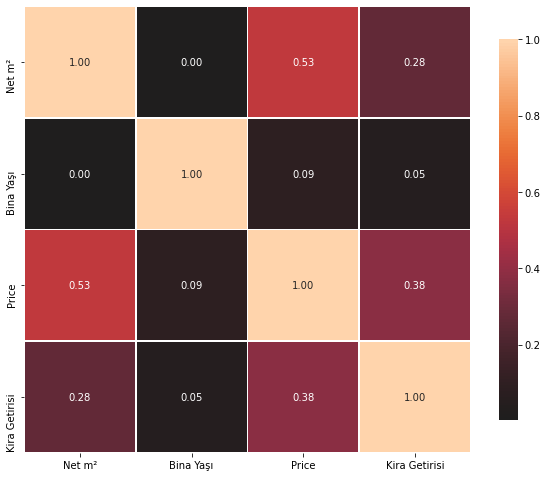

In [27]:
correlation_heatmap(dataset_temp)

In [28]:
#Dropped unnecessary column
dataset = dataset.drop("index", axis = 1)
dataset

,Brüt m²,Net m²,Oda Sayısı,Banyo Sayısı,Bina Yaşı,Kira Getirisi,Krediye Uygun,Price,Location Lat,Location Lon,...,Bulunduğu Kat_Komple,Bulunduğu Kat_Kot 1,Bulunduğu Kat_Kot 2,Bulunduğu Kat_Kot 3,Bulunduğu Kat_Kot 4,Bulunduğu Kat_Müstakil,Bulunduğu Kat_Teras Kat,Bulunduğu Kat_Yüksek Giriş,Bulunduğu Kat_Zemin Kat,Bulunduğu Kat_Çatı Katı
0,95,85.0,3.0,1,0.0,0.046823,0,325000,41.056436,28.924630,...,0,0,0,0,0,0,0,0,0,0
1,152,102.0,4.0,2,0.0,0.057549,1,550000,41.125386,28.765559,...,0,0,0,0,0,0,0,0,0,0
2,125,90.0,3.0,2,0.0,0.057549,0,410000,41.010598,28.682872,...,0,0,0,0,0,0,0,0,0,0
3,175,160.0,4.0,2,2.0,0.057549,0,370000,40.976841,28.675703,...,0,0,0,0,0,0,0,0,0,0
4,166,150.0,4.0,2,0.0,0.057549,0,1530000,40.988106,28.883287,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,87,85.0,3.0,1,23.0,0.057549,1,182500,41.043377,28.863824,...,0,0,0,0,0,0,0,0,0,0
4808,100,90.0,3.0,2,0.0,0.057549,0,750000,40.986000,29.029634,...,0,0,0,0,0,0,0,0,0,0
4809,300,280.0,5.0,3,13.0,0.057549,0,5500000,41.120947,29.042263,...,0,0,0,0,0,0,0,0,0,0
4810,110,87.0,3.0,1,28.0,0.057549,0,1150000,41.045158,29.051027,...,0,0,0,0,0,0,0,0,0,0


In [29]:
X=dataset.drop("Price",axis=1)
y=dataset["Price"]

In [30]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=42) #making changes on test size affects r scores of ridge,lasso
                                                                                  #and linear regression too much. 0.2 and 0.3 test sizes give negative
                                                                                  #R scores.

In [31]:
reg = LinearRegression()
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

print("Accuracy on Traing set: ",reg.score(X_train,y_train))
print("Accuracy on Testing set: ",reg.score(X_test,y_test))
print(r2_score(y_test,pred))

Accuracy on Traing set:  0.4705017637858959
Accuracy on Testing set:  0.5403536813175258
0.5403536813175258


In [32]:
ridge = Ridge(alpha = 0.0001, max_iter = 1000)
ridge.fit(X_train, y_train)
pred_2=ridge.predict(X_test)

print("Accuracy on Traing set: ",ridge.score(X_train,y_train))
print("Accuracy on Testing set: ",ridge.score(X_test,y_test))
print(r2_score(y_test,pred_2))

Accuracy on Traing set:  0.4705017637746738
Accuracy on Testing set:  0.5403521408772706
0.5403521408772706


In [33]:
lasso = Lasso(alpha=0.00001, max_iter = 1000)
lasso.fit(X_train, y_train)
pred_3 = lasso.predict(X_test)

print("Accuracy on Traing set: ",lasso.score(X_train,y_train))
print("Accuracy on Testing set: ",lasso.score(X_test,y_test))
print(r2_score(y_test,pred_3))

Accuracy on Traing set:  0.47050176378589614
Accuracy on Testing set:  0.5403536812439267
0.5403536812439267


In [34]:
ran=RandomForestRegressor(min_impurity_decrease = 1)#n_estimators = 100, max_features = 'sqrt', max_depth = 10, random_state = 42
ran.fit(X_train, y_train)
y_pred=ran.predict(X_test)

print("Accuracy on Traing set: ",ran.score(X_train,y_train))
print("Accuracy on Testing set: ",ran.score(X_test,y_test))
print(r2_score(y_test,y_pred))

Accuracy on Traing set:  0.9482198890931723
Accuracy on Testing set:  0.6271727511895901
0.6271727511895901


In [35]:
final_untouched_data = dataset[-100:]
training_data = dataset[:-100]

Actual Price: 1350000 | Predicted Price: 1253440.0
Actual Price: 219000 | Predicted Price: 238975.0
Actual Price: 175000 | Predicted Price: 202690.0
Actual Price: 359000 | Predicted Price: 370150.0
Actual Price: 208000 | Predicted Price: 209060.0
Actual Price: 210000 | Predicted Price: 209350.0
Actual Price: 739000 | Predicted Price: 725219.8366666666
Actual Price: 119000 | Predicted Price: 132873.97416666668
Actual Price: 525000 | Predicted Price: 491735.0
Actual Price: 3000000 | Predicted Price: 3591350.0
Actual Price: 305000 | Predicted Price: 305740.0
Actual Price: 220000 | Predicted Price: 245764.99
Actual Price: 369000 | Predicted Price: 388665.0
Actual Price: 460000 | Predicted Price: 556245.0
Actual Price: 475000 | Predicted Price: 456170.0
Actual Price: 190000 | Predicted Price: 189970.0
Actual Price: 1525000 | Predicted Price: 1217240.0
Actual Price: 670000 | Predicted Price: 749480.0
Actual Price: 850000 | Predicted Price: 1002274.98
Actual Price: 875000 | Predicted Price: 5

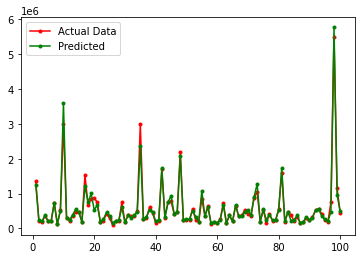

In [36]:
feature_final_untouched = final_untouched_data.drop(['Price'], axis= 1)
target_final_untouched = final_untouched_data['Price']
feature_final_untouched

untouched_data_predictions = ran.predict(feature_final_untouched)

 
target_final_untouched = np.array(target_final_untouched)

for i in range(len(target_final_untouched)):
    print('Actual Price: {} | Predicted Price: {}'.format(target_final_untouched[i], untouched_data_predictions[i]
                                                         ))    
x = np.arange(1, target_final_untouched.shape[0]+1)

plt.plot(x, target_final_untouched, marker='.', color='red')
plt.plot(x, untouched_data_predictions, marker='.', color='green')
plt.legend(['Actual Data', 'Predicted'])
plt.show()

[8.09347705e-02 8.22693392e-02 3.69091751e-02 2.69296856e-02
 5.36074558e-02 4.86676611e-02 1.29368556e-02 9.10747340e-02
 9.24606573e-02 4.21690527e-02 2.32584128e-04 4.10554598e-03
 4.41167574e-04 4.36133718e-03 1.02993339e-02 6.08494146e-05
 3.30491865e-03 6.60786154e-03 1.19762371e-03 4.68910898e-04
 1.87554819e-03 4.64504013e-04 4.40863318e-03 1.62519729e-02
 4.87461378e-03 7.28090739e-03 1.62653150e-02 1.20178866e-02
 1.13082746e-02 1.78279521e-02 1.35052113e-03 1.71225626e-02
 1.33644708e-03 1.78419162e-02 1.90213506e-03 3.70188339e-03
 2.74590379e-03 4.76798255e-03 3.57460016e-03 8.30102784e-04
 2.39600975e-03 2.41861345e-04 5.74002388e-03 2.19450452e-02
 5.47943952e-03 9.46553362e-04 4.94270067e-03 6.92158853e-03
 1.85210540e-03 3.01838604e-03 9.85617280e-03 1.48821405e-02
 1.63139007e-02 1.02429307e-02 5.68918675e-03 5.30937182e-03
 5.13910569e-03 1.46572387e-02 2.65629216e-03 2.08478629e-03
 1.60366741e-03 1.26255702e-03 9.08614211e-04 4.26174941e-04
 3.84122944e-04 4.115812

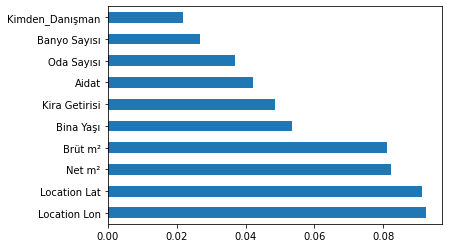

In [37]:
#top 10 features have most effect on output
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [38]:
#R scores of xgboost
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.6, learning_rate = 0.5,
                max_depth =5, alpha = 5, n_estimators = 900)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)
print("Accuracy on Traing set: ",xg_reg.score(X_train,y_train))
print("Accuracy on Testing set: ",xg_reg.score(X_test,y_test))
print(r2_score(y_test,y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

[10:19:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy on Traing set:  0.9999929150117124
Accuracy on Testing set:  0.7900982259139867
0.7900982259139867


In [39]:
param_distributions = {'max_depth': randint(2,7),'colsample_bytree' : uniform.rvs(size=10), 'learning_rate' : uniform.rvs(size=10)}
search = RandomizedSearchCV(estimator=xgb.XGBRegressor(n_estimators = 70, random_state=0), n_iter=20, param_distributions=param_distributions,
                            random_state=0)
search.fit(X_train,y_train)
search_pred = search.predict(X_test)
print("Accuracy on Traing set: ",search.score(X_train,y_train))
print("Accuracy on Testing set: ",search.score(X_test,y_test))
print(r2_score(y_test,search_pred))

Accuracy on Traing set:  0.9663269410978697
Accuracy on Testing set:  0.5625862282640881
0.5625862282640881


In [40]:
ANN = MLPRegressor(hidden_layer_sizes = (250,175,100), random_state=1, max_iter=1000, alpha = 0.01, learning_rate_init = 0.01).fit(X_train, y_train)
ANN_pred = ANN.predict(X_test)
print("Accuracy on Traing set: ",ANN.score(X_train,y_train))
print("Accuracy on Testing set: ",ANN.score(X_test,y_test))
print(r2_score(y_test,ANN_pred))

Accuracy on Traing set:  0.886179790751539
Accuracy on Testing set:  0.7530285402686852
0.7530285402686852


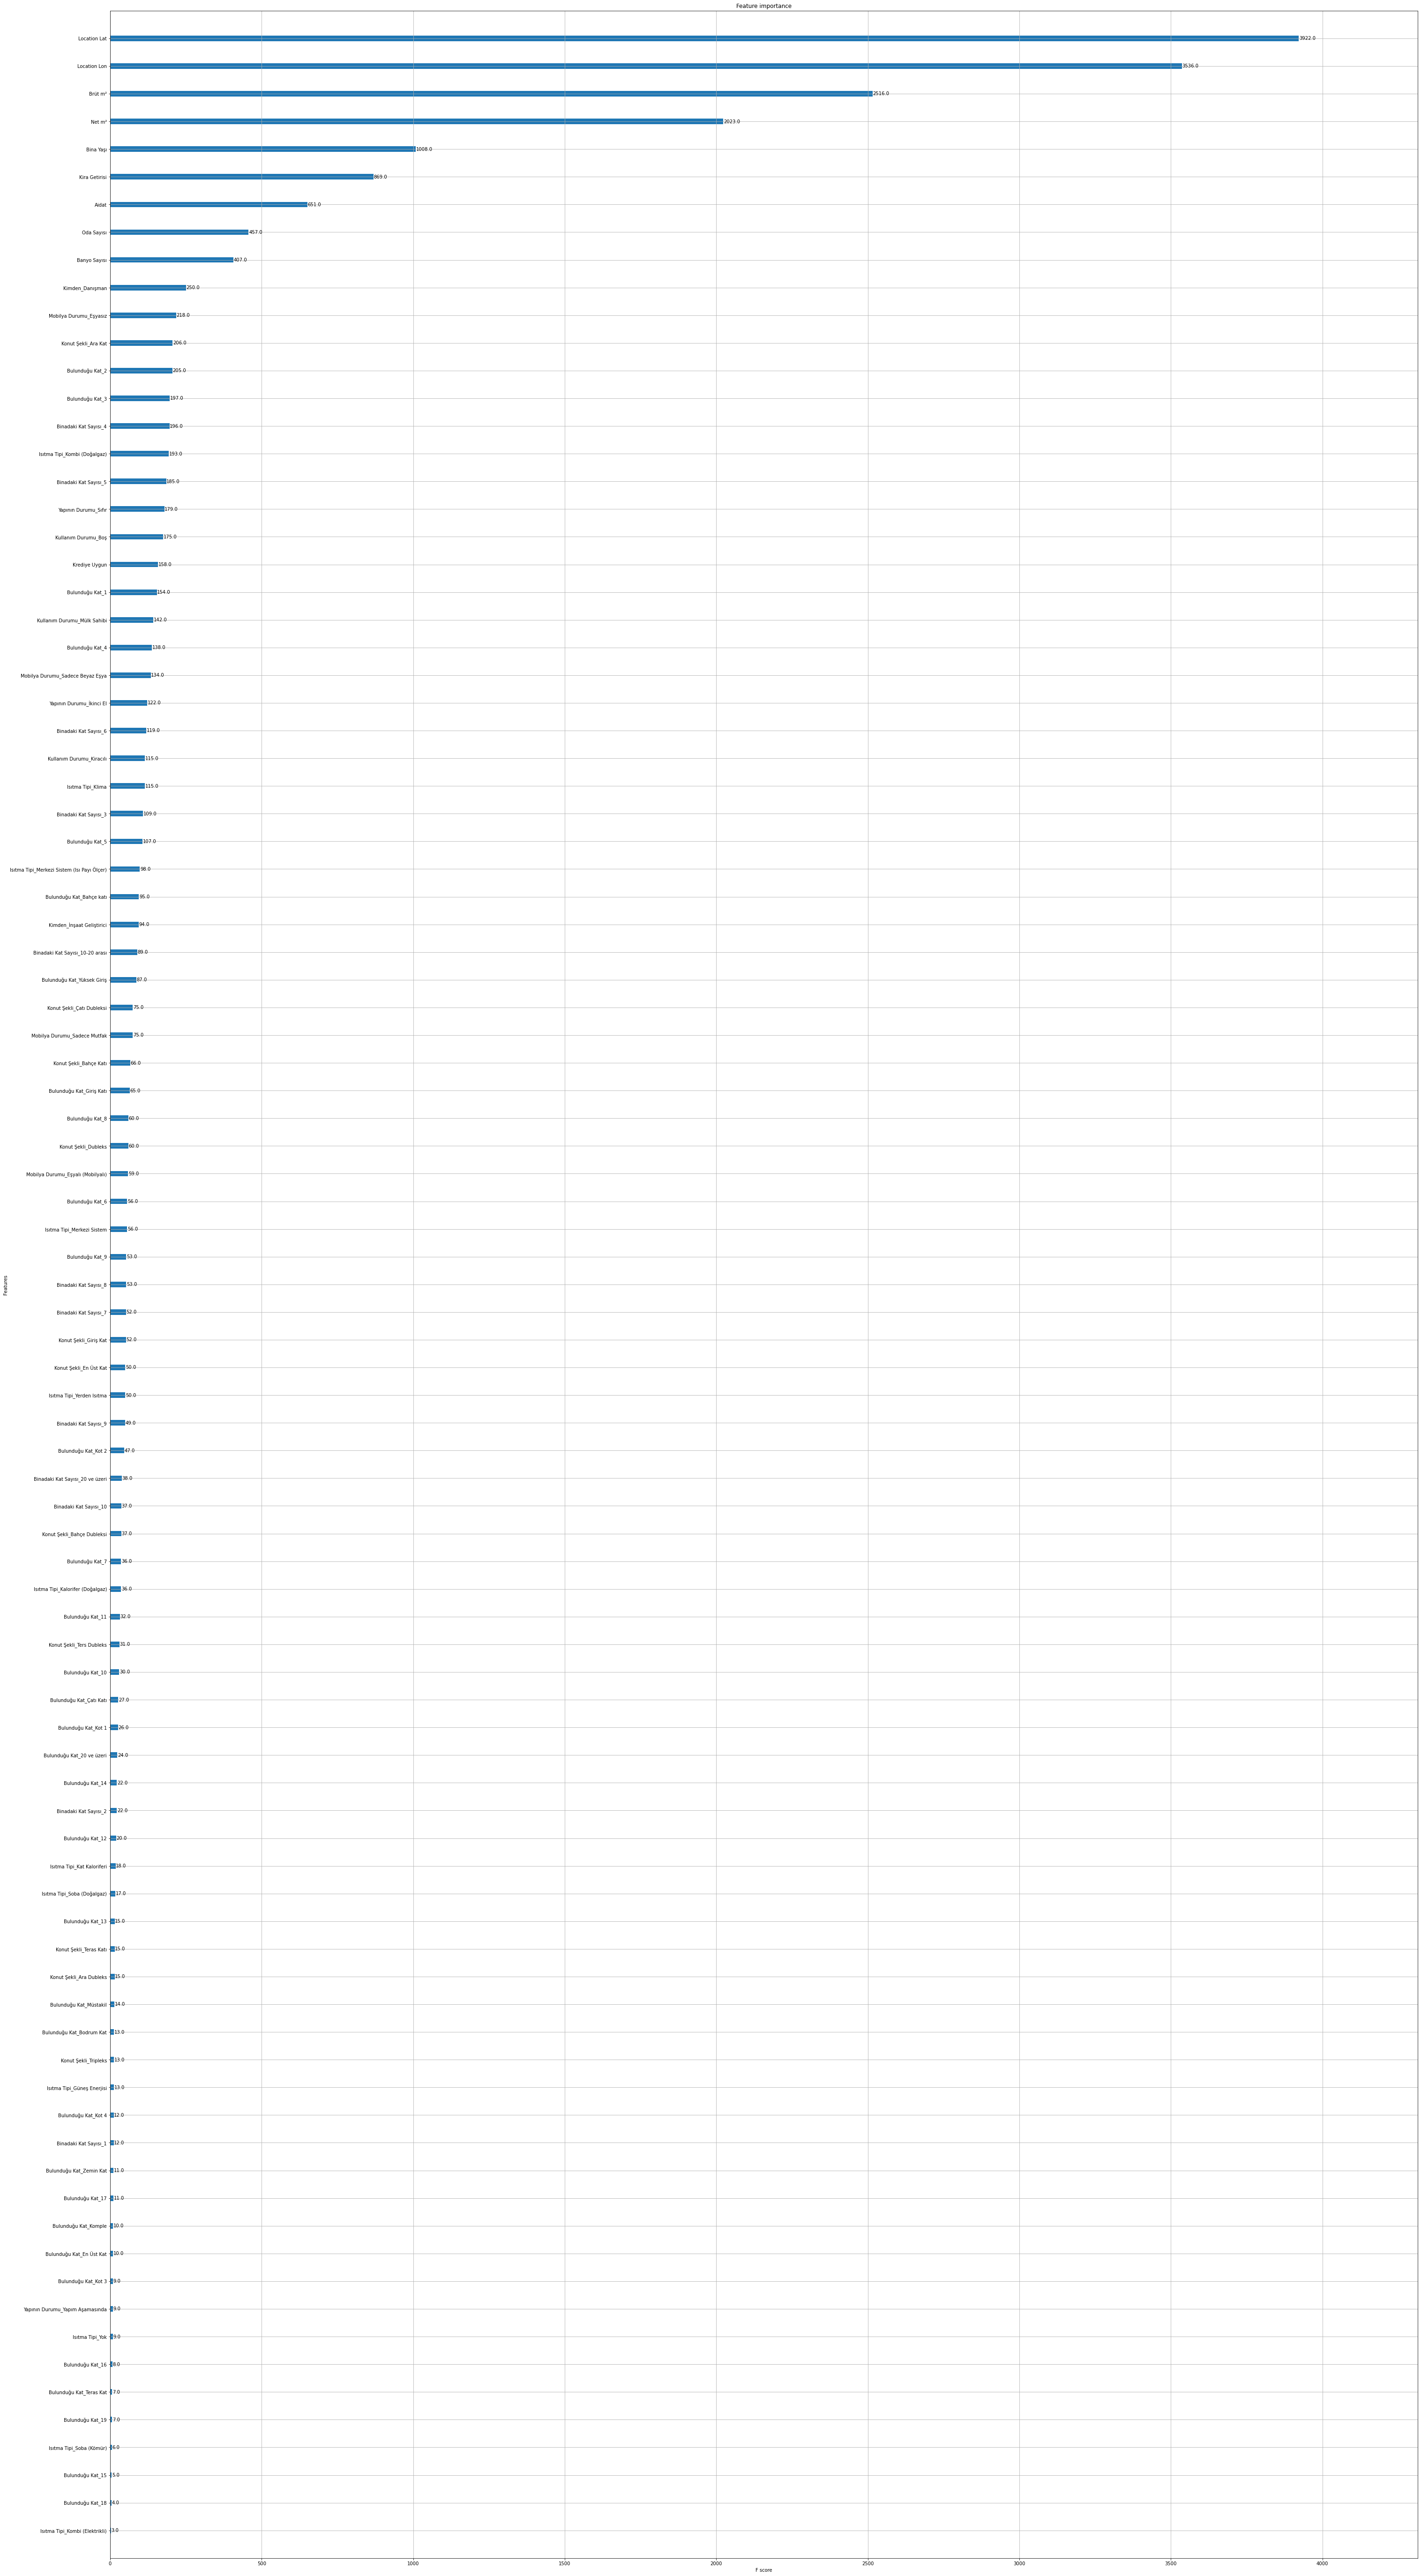

In [60]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [30,100]
plt.show()

In [42]:
dataset_2 = dataset.reindex(columns = [col for col in dataset.columns if col != 'Price'] + ['Price'])
dataset_2

,Brüt m²,Net m²,Oda Sayısı,Banyo Sayısı,Bina Yaşı,Kira Getirisi,Krediye Uygun,Location Lat,Location Lon,Aidat,...,Bulunduğu Kat_Kot 1,Bulunduğu Kat_Kot 2,Bulunduğu Kat_Kot 3,Bulunduğu Kat_Kot 4,Bulunduğu Kat_Müstakil,Bulunduğu Kat_Teras Kat,Bulunduğu Kat_Yüksek Giriş,Bulunduğu Kat_Zemin Kat,Bulunduğu Kat_Çatı Katı,Price
0,95,85.0,3.0,1,0.0,0.046823,0,41.056436,28.924630,150.940587,...,0,0,0,0,0,0,0,0,0,325000
1,152,102.0,4.0,2,0.0,0.057549,1,41.125386,28.765559,150.940587,...,0,0,0,0,0,0,0,0,0,550000
2,125,90.0,3.0,2,0.0,0.057549,0,41.010598,28.682872,150.940587,...,0,0,0,0,0,0,0,0,0,410000
3,175,160.0,4.0,2,2.0,0.057549,0,40.976841,28.675703,50.000000,...,0,0,0,0,0,0,0,0,0,370000
4,166,150.0,4.0,2,0.0,0.057549,0,40.988106,28.883287,150.940587,...,0,0,0,0,0,0,0,0,0,1530000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,87,85.0,3.0,1,23.0,0.057549,1,41.043377,28.863824,25.000000,...,0,0,0,0,0,0,0,0,0,182500
4808,100,90.0,3.0,2,0.0,0.057549,0,40.986000,29.029634,45.000000,...,0,0,0,0,0,0,0,0,0,750000
4809,300,280.0,5.0,3,13.0,0.057549,0,41.120947,29.042263,150.940587,...,0,0,0,0,0,0,0,0,0,5500000
4810,110,87.0,3.0,1,28.0,0.057549,0,41.045158,29.051027,150.940587,...,0,0,0,0,0,0,0,0,0,1150000


In [43]:
X, y = dataset_2.iloc[:,:-1],dataset_2.iloc[:,-1]

In [44]:
y

0        325000
1        550000
2        410000
3        370000
4       1530000
         ...   
4807     182500
4808     750000
4809    5500000
4810    1150000
4811     445000
Name: Price, Length: 4811, dtype: int64

In [45]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [46]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10, as_pandas=True, seed=123)

In [47]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.218910e+06,38771.545595,1.207599e+06,176710.537269
1,1.155649e+06,40501.723620,1.155061e+06,176733.747214
2,1.094016e+06,47079.425302,1.106580e+06,171967.240607
3,1.041142e+06,41041.878072,1.070388e+06,175008.708271
4,9.830284e+05,33451.901201,1.020756e+06,169815.194472


In [48]:
print((cv_results["test-rmse-mean"]).tail(1))

49    667743.085427
Name: test-rmse-mean, dtype: float64


In [49]:
#Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. 
#In other words, it tells you how concentrated the data is around the line of best fit. For example, if the correlation coefficient is 1, the RMSE will be 0, because all of the points lie on the regression line (and therefore there are no errors).

### Model Testing

In [50]:
separate_df = dataset.sample(frac=0.1, random_state=42)

In [51]:
separate_df

,Brüt m²,Net m²,Oda Sayısı,Banyo Sayısı,Bina Yaşı,Kira Getirisi,Krediye Uygun,Price,Location Lat,Location Lon,...,Bulunduğu Kat_Komple,Bulunduğu Kat_Kot 1,Bulunduğu Kat_Kot 2,Bulunduğu Kat_Kot 3,Bulunduğu Kat_Kot 4,Bulunduğu Kat_Müstakil,Bulunduğu Kat_Teras Kat,Bulunduğu Kat_Yüksek Giriş,Bulunduğu Kat_Zemin Kat,Bulunduğu Kat_Çatı Katı
1448,98,80.0,3.0,1,1.000000,0.030100,0,255000,41.018197,29.226817,...,0,0,0,0,0,0,0,0,0,0
2934,120,100.0,4.0,1,8.000000,0.080268,0,650000,41.082176,28.972338,...,0,0,0,0,0,0,0,0,0,0
794,85,70.0,3.0,1,0.000000,0.057549,0,269999,41.144594,28.461896,...,0,0,0,0,0,0,0,0,0,0
1029,101,85.0,3.0,1,0.000000,0.057549,0,350000,41.013292,28.685356,...,0,0,0,0,0,0,0,0,0,0
8,282,181.0,5.0,5,6.279554,0.057549,0,2750000,40.958811,29.092215,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3777,135,125.0,4.0,1,18.000000,0.057549,1,320000,40.942208,29.147276,...,0,0,0,0,0,0,0,0,0,0
4334,110,80.0,2.0,1,18.000000,0.030100,1,140000,41.060906,28.862205,...,0,0,0,0,0,0,0,0,0,0
734,80,70.0,2.0,1,0.000000,0.057549,0,95000,41.011699,28.638736,...,0,0,0,0,0,0,0,0,0,0
4338,125,107.0,4.0,2,0.000000,0.130435,0,1050000,40.958028,29.085734,...,0,0,0,0,0,0,0,0,0,0


In [52]:
X_sepdf=separate_df.drop("Price",axis=1)
y_sepdf=separate_df["Price"]

In [53]:
test_pred = reg.predict(X_sepdf)
print("Accuracy on Testing set: ",reg.score(X_sepdf,y_sepdf))
print(r2_score(y_sepdf,test_pred))

Accuracy on Testing set:  0.540320642193475
0.540320642193475


In [54]:
test_pred_2=ridge.predict(X_sepdf)
print("Accuracy on Testing set: ",ridge.score(X_sepdf,y_sepdf))
print(r2_score(y_sepdf,test_pred_2))

Accuracy on Testing set:  0.5403191019483387
0.5403191019483387


In [55]:
test_pred_3 = lasso.predict(X_sepdf)
print("Accuracy on Testing set: ",lasso.score(X_sepdf,y_sepdf))
print(r2_score(y_sepdf,test_pred_3))

Accuracy on Testing set:  0.5403206421199584
0.5403206421199584


In [56]:
test_pred_4=ran.predict(X_sepdf)
print("Accuracy on Testing set: ",ran.score(X_sepdf,y_sepdf))
print(r2_score(y_sepdf,test_pred_4))

Accuracy on Testing set:  0.6271284003347848
0.6271284003347848


In [57]:
test_pred_5 = xg_reg.predict(X_sepdf)
print("Accuracy on Testing set: ",xg_reg.score(X_sepdf,y_sepdf))
print(r2_score(y_sepdf,test_pred_5))
rmse = np.sqrt(mean_squared_error(y_sepdf, test_pred_5))

Accuracy on Testing set:  0.7901153410952095
0.7901153410952095


In [58]:
test_pred_6 = search.predict(X_sepdf)
print("Accuracy on Testing set: ",search.score(X_sepdf,y_sepdf))
print(r2_score(y_sepdf,test_pred_6))

Accuracy on Testing set:  0.5625345044963974
0.5625345044963974


In [59]:
test_pred_7 = ANN.predict(X_sepdf)
print("Accuracy on Testing set: ",ANN.score(X_sepdf,y_sepdf))
print(r2_score(y_sepdf,test_pred_7))

Accuracy on Testing set:  0.7530254078909383
0.7530254078909383
